In [26]:
import pickle
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import re
import matplotlib.pyplot as plt
import scipy.stats as st

# CDF 

In [27]:
def ks_plot_comp(data_1, data_2):
    plt.figure(figsize=(12, 7))
    plt.scatter(data_1, range(len(data_1)), label="base loss", alpha=0.3, s=2)
    plt.scatter(data_2, range(len(data_2)), label="attack loss", alpha=0.3, s=2)
    plt.legend('top right')
    plt.title('Comparing 2 data distributions for KS-Test')
    plt.show()
    
def batch_pvals(loss1, loss2):
    batch_size = 16
    stats = []
    pvals = []
    for i in range(0, len(loss2), batch_size):
        loss_batch2 = loss2[i:i+batch_size]
        result = ks_2samp(loss1, loss_batch2, alternative="greater")
        stats.append(result[0])
        pvals.append(result[1])
    return stats, pvals

In [28]:
with open("output/base_loss.pkl", "rb") as f:
    base_loss_values = pickle.load(f)

In [32]:
with open("output/fgsm4_mixed2.pkl", "rb") as f:
    fgsm4_mixed = pickle.load(f)

with open("output/fgsm4_loss.pkl", "rb") as f:
    fgsm4_clean = pickle.load(f)

In [30]:
len(base_loss_values)

50000

In [33]:
len(fgsm4_clean)

50000

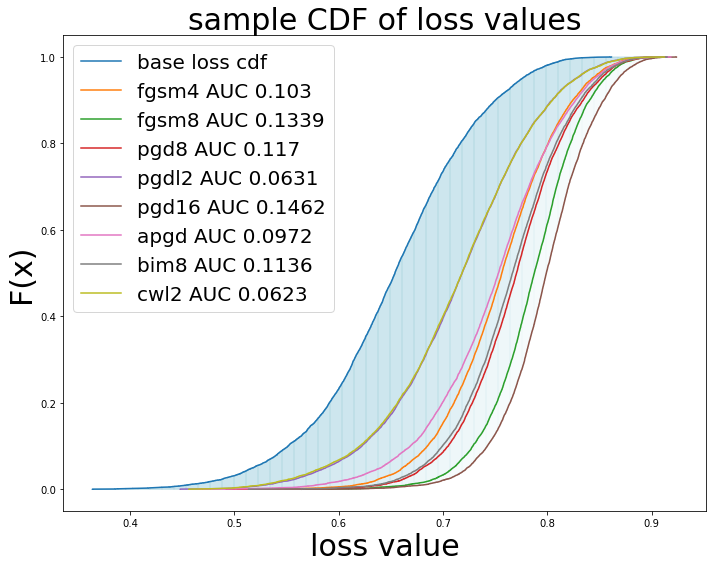

In [96]:
attacks = ["fgsm4", "fgsm8", "pgd8", "pgdl2", "pgd16", "apgd", "bim8", "cwl2"]
# attacks = ["fgsm4", "fgsm8", "pgd8", "pgdl2", "pgd16", "apgd"]

plt.figure(figsize=(10, 8))
samp_a = np.sort(base_loss_values)
p = 1. * np.arange(len(samp_a)) / (len(samp_a) - 1)
plt.plot(samp_a, p, label="base loss cdf")

for attack in attacks:
    path = "output/" + attack + "_loss.pkl"
    with open(path, "rb") as f:
        clean_data = pickle.load(f)

    data_sorted = np.sort(clean_data)
    p1 = 1. * np.arange(len(data_sorted)) / (len(data_sorted) - 1)
    plt.plot(data_sorted, p1, label=f"{attack} AUC {np.round(np.trapz(data_sorted - base_loss_values, p1), 4)}")
    
    plt.fill_betweenx(p1, samp_a, data_sorted, color="lightblue", alpha=0.1, hatch='|')

plt.title("sample CDF of loss values", fontsize=30)
plt.xlabel("loss value", fontsize=30)
plt.ylabel("F(x)", fontsize=30)
plt.legend(prop={'size':20})

plt.tight_layout() #gap size
plt.savefig("mae_cdf.png", dpi=200)

# ROC

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, auc

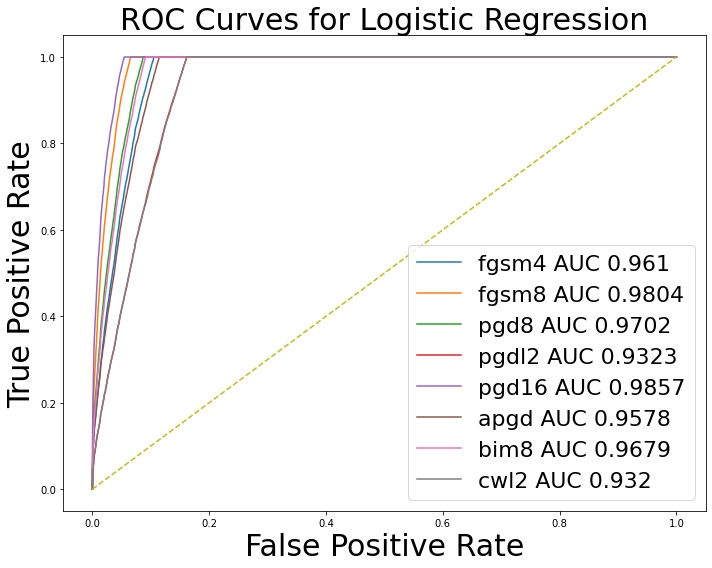

In [95]:
attacks = ["fgsm4", "fgsm8", "pgd8", "pgdl2", "pgd16", "apgd", "bim8", "cwl2"]

plt.figure(figsize=(10, 8))
samp_a = np.sort(base_loss_values)
# p = 1. * np.arange(len(samp_a)) / (len(samp_a) - 1)
# plt.plot(samp_a, p, label="base loss cdf")

for attack in attacks:
    path = "output/" + attack + "_mixed2.pkl"
    with open(path, "rb") as f:
        samp_b = np.sort(pickle.load(f))
    samp_b_clean = np.sort(samp_b[0:len(samp_a)])
    samp_b_attack = np.sort(samp_b[len(samp_a):])

    X = np.concatenate((samp_a, samp_b))
    X = np.vstack((X, np.ones(len(X)))).transpose()
    y = np.concatenate((np.zeros(len(samp_a) + len(samp_b_clean)), np.ones(len(samp_b_attack))))

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=88, test_size=0.2)

    clf_reg = LogisticRegression()
    clf_reg.fit(X_train, y_train)

    proba = clf_reg.predict_proba(X_train)[:,1]
    fpr, tpr, threshold = roc_curve(y_train, proba)
    
    plt.plot(fpr, tpr, label=f"{attack} AUC {np.round(auc(fpr, tpr), 4)}")

plt.plot([0, 1], ls="--")
plt.title("ROC Curves for Logistic Regression", fontsize=30)
plt.ylabel("True Positive Rate", fontsize=30)
plt.xlabel("False Positive Rate", fontsize=30)
plt.legend(prop={'size':22})

plt.tight_layout() #gap size
plt.savefig("mae_roc.png", dpi=200)